In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

import spacy
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier

stopwords = set(stopwords.words("english"))
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [153]:
df = pd.read_csv('train_spam.csv')

X = df['text']
y = df['text_type'].map({'ham': 0, 'spam': 1})

In [94]:
df_spam = df[df.iloc[:, 0] == 'spam']
df_ham = df[df.iloc[:, 0] == 'ham']

In [165]:
df_spam.shape, df_ham.shape

((4809, 2), (11469, 2))

Text(0, 0.5, 'Частота')

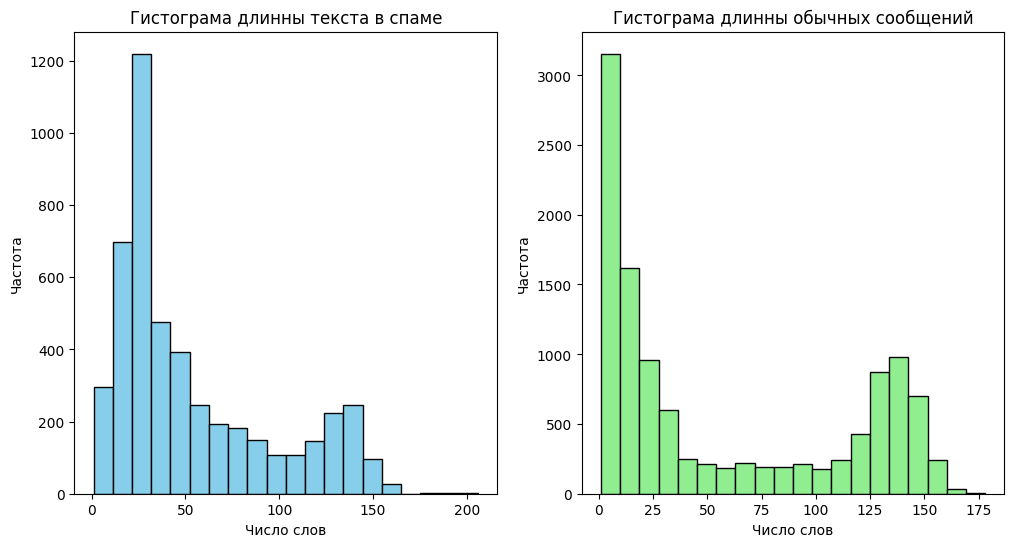

In [169]:
spam_lengths = df_spam['text'].apply(lambda x: len(x.split()))
ham_lengths = df_ham['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].hist(spam_lengths, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Гистограма длинны текста в спаме')
axes[0].set_xlabel('Число слов')
axes[0].set_ylabel('Частота')

axes[1].hist(ham_lengths, bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title('Гистограма длинны обычных сообщений')
axes[1].set_xlabel('Число слов')
axes[1].set_ylabel('Частота')

Хоть распредление количеста слов в сообщениях примерно одинаковое, мы можем заметить сильный дизбаланс классов, поэтому использовать метрику accuracy не будет хорошим решением. Вместо нее можно рассмотреть меру F1 или ROC AUC, которая и будет взята за базовую

Для токенизации будем использовать библеотеку spacy и лемматизацию слов, чтобы не хранить одни и те же слова, но с разными окончаниями. Также уберем стоп слова по типу me, there, and, about... которые не несут значимой информации


In [ ]:
nlp = spacy.load('en_core_web_sm')
def tokenize_line(line):
    line = re.sub(r'[^\w\s]', '', line)
    spacy_res = nlp(line)
    line = ' '.join([token.lemma_ for token in spacy_res if token.lemma_ not in stopwords])
    return line

line = 'Man What a good weather today, Buy a new iphone for free! Just visiting our site...'
print(tokenize_line(line))

In [110]:
spam_messages =  [tokenize_line(line) for line in list(df_spam.iloc[:, 1])]
ham_messages = [tokenize_line(line) for line in list(df_ham.iloc[:, 1])]
len(ham_messages)

11469

Посмотрим какие слова встречаются чаще всего в спаме. Среди них можно увидеть характерные для спама слова такие как free, help, new, invest, contact, earn, buy, offer, call

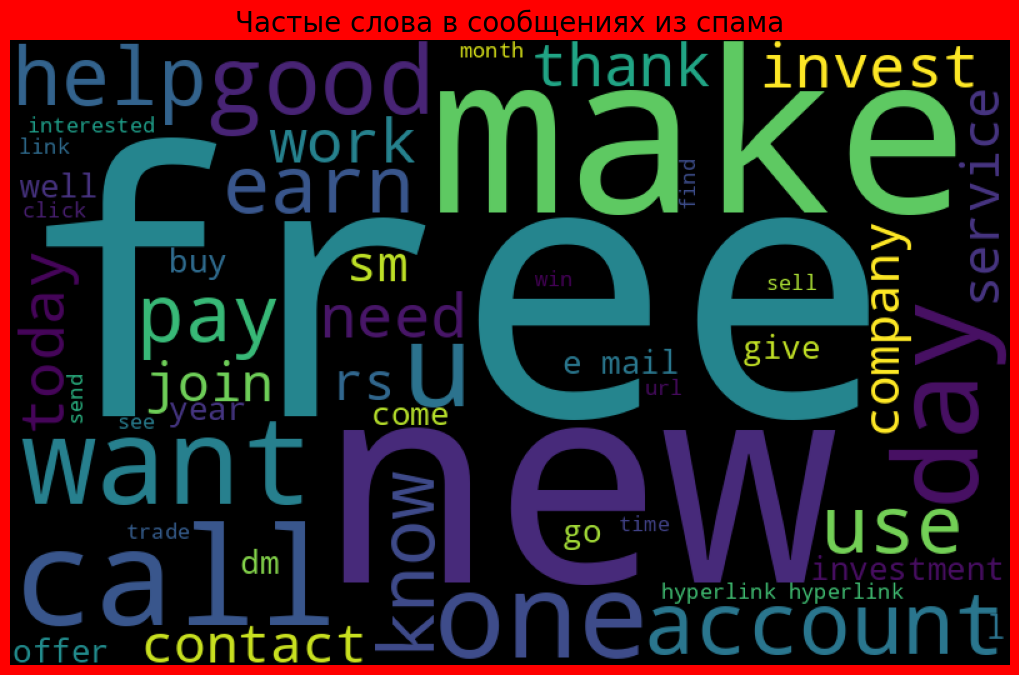

In [155]:
spam_cloud = WordCloud(width=800,height=500,background_color='black',max_words=50).generate(' '.join(spam_messages))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.title("Частые слова в сообщениях из спама",fontsize=20);
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

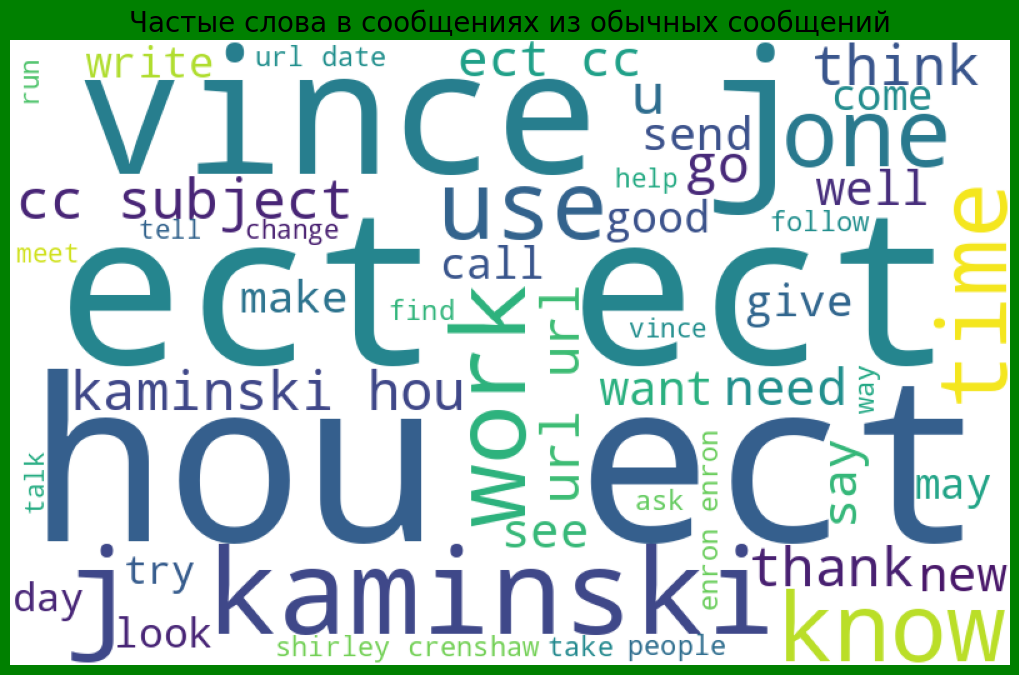

In [156]:
spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(ham_messages))

plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(spam_cloud)
plt.title("Частые слова в обычных сообщениях",fontsize=20);

plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Для кодирования слов будет использовать подход TF-IDF в силу его простоты

In [162]:
vectorizor = TfidfVectorizer()
vectors = vectorizor.fit_transform(X)
vectors.shape #закодированные сообщение без предобработки. Слишком большие векторы

(16278, 53378)

In [163]:
better_text = [tokenize_line(line) for line in X]

Было проверено, что 2000 фичей является опимальным значением. Меньше - теряется точность, больше - вычисления становятся дольше и точность не сильно меняется. Также было попробованно взять разные n граммы и лучшим вариантом оказался униграмм

In [171]:
vectorizor = TfidfVectorizer(max_features=2000, ngram_range=(1,1))
vectors = vectorizor.fit_transform(better_text)
vectors.shape

(16278, 2000)

In [178]:
dense_vectors = vectors.todense()
X_train, X_test, y_train, y_test = train_test_split(dense_vectors, y, test_size= 0.2, random_state=69)

In [179]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train.sum()

3830

In [180]:
svm = svm.SVC()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)
print("ROC AUC Score:", roc_auc)
print(acc, f1)

ROC AUC Score: 0.9182543559680832
0.9434889434889435 0.9009687836383208


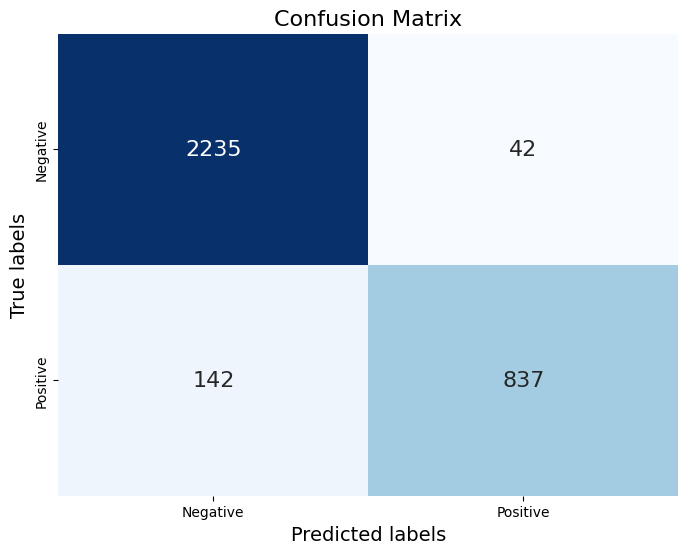

In [181]:
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16}, cbar=False)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.show()

In [182]:
sgd = SGDClassifier().fit(X_train, y_train)
pred = sgd.predict(X_test)
acc = accuracy_score(y_test, sgd.predict(X_test))
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)
print("ROC AUC Score:", roc_auc)
print(acc, f1)

ROC AUC Score: 0.9085505766013826
0.9376535626535627 0.8896139206090267


In [183]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
pred2 = clf.predict(X_test)
acc = accuracy_score(y_test, pred2)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)
print("ROC AUC Score:", roc_auc)
print(acc, f1)

ROC AUC Score: 0.9085505766013826
0.8943488943488943 0.8896139206090267


In [185]:
clf = MultinomialNB(alpha=0.2)
clf.fit(X_train, y_train)
y_pred_nb = clf.predict(X_test)
f1 = f1_score(y_test, y_pred_nb)
roc_auc = roc_auc_score(y_test, y_pred_nb)
print("ROC AUC Score:", roc_auc)
print(acc, f1)

ROC AUC Score: 0.896468347372109
0.8943488943488943 0.8623949579831932


In [85]:
model = CatBoostClassifier(iterations=400, learning_rate=0.1, depth=8)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

0:	learn: 0.6370222	total: 2.12s	remaining: 14m 6s
1:	learn: 0.5845585	total: 3.11s	remaining: 10m 18s
2:	learn: 0.5578100	total: 4.05s	remaining: 8m 56s
3:	learn: 0.5375438	total: 4.69s	remaining: 7m 44s
4:	learn: 0.5215721	total: 5.31s	remaining: 6m 59s
5:	learn: 0.5071038	total: 5.95s	remaining: 6m 30s
6:	learn: 0.4935726	total: 6.57s	remaining: 6m 8s
7:	learn: 0.4818596	total: 7.17s	remaining: 5m 51s
8:	learn: 0.4631146	total: 7.78s	remaining: 5m 38s
9:	learn: 0.4553752	total: 8.36s	remaining: 5m 26s
10:	learn: 0.4463131	total: 8.95s	remaining: 5m 16s
11:	learn: 0.4379866	total: 9.53s	remaining: 5m 8s
12:	learn: 0.4322145	total: 10.1s	remaining: 5m 1s
13:	learn: 0.4259858	total: 10.7s	remaining: 4m 55s
14:	learn: 0.4202364	total: 11.3s	remaining: 4m 50s
15:	learn: 0.4135959	total: 11.9s	remaining: 4m 45s
16:	learn: 0.4074985	total: 12.5s	remaining: 4m 41s
17:	learn: 0.4027200	total: 13.1s	remaining: 4m 37s
18:	learn: 0.3983272	total: 13.7s	remaining: 4m 34s
19:	learn: 0.3940174	tot

In [127]:
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)


F1 Score: 0.9293067623983755
ROC AUC Score: 0.8987522753084307


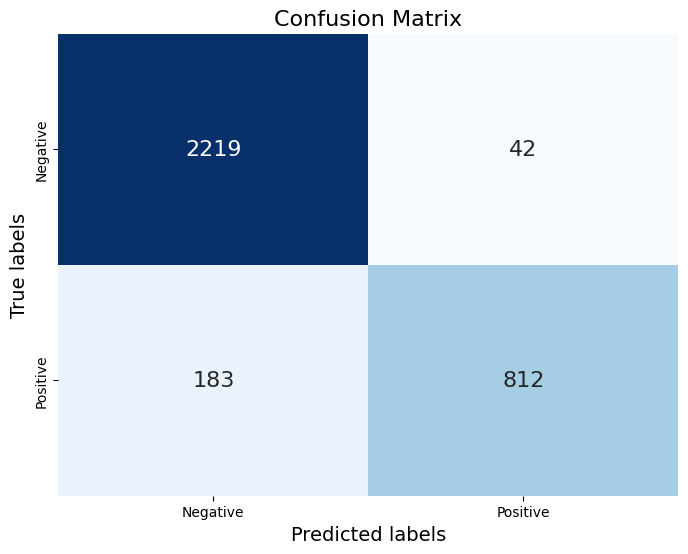

In [128]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16}, cbar=False)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.show()

Таким образом, среди всех линейных моделей по метрике ROC AUC выигрывает метод опорных векторов (92%), хотя проигрывает градиентному бустингу по точности и F1 мере. В следующем ноутбуке будет разобрана глубокая модель Bidirectional LSTM, которая справилась с классификацией еще лучше и достигла 0.96 по ROC AUC
